In [1]:
import pyodbc as pyodbc

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#configuration
pd.set_option('float_format', '{:.0f}'.format)
mydateparser = lambda x: pd.datetime.strptime(x, "%d/%m/%y")

#sector related variables


In [2]:
#############################
# Define the directory
#############################

# Folder that hold outputs
outDir  = 'C://Users//Wanthana.J//AzureML//Netflix//customerIntensity//data//'


In [7]:
#######################################################################################################################################
# Extract Data
########################################################################################################################################
server = 'tcp:ausse-nzte-sqlrepp1.database.windows.net'
database = 'prdCRMReport'
driver = '{ODBC Driver 17 for SQL Server}'
username = 'prdCRMReport_Admin_Read'
password = '?ZvEHun3PE$E793G'
cnxn = pyodbc.connect('DRIVER=' + driver +';SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
###################################################################################################################

attributes = ["Organisation NZTE Sector", "Organisation NZTE Segment", "Organisation Manager" , "Organisation Maori Customer", "Organisation Age in Focus (Months)" , "Organisation Director",              "SnapshotNZDate"]

sql_focus_snapshots = """
            select [Organisation Key]
            , [Organisation Legal Name]
            , [Organisation NZTE Sector]
            , [Organisation NZTE Segment]
            , [Organisation Entry To Segment Date]
            , [Organisation Manager]
            , [Organisation Manager Key]
            , [Organisation Maori Customer]
            , [Organisation Age in Focus (Months)]
            , [Organisation Director Key]
            , [Organisation Director]
            , [Organisation Previous NZTE Segment]
            , [SnapshotNZDate]  
            from [CRM_Snapshot].[Organisations] o
            where [SnapshotNZDate]  >= '2019-07-02'
            and [Organisation NZTE Segment] like 'Focus%'
            """
focus_snapshot = pd.read_sql(sql_focus_snapshots, cnxn)
##############################################################################################################

exported_date = pd.to_datetime("today").strftime("%Y%m%d")
outfilePath = outDir + "focus_snapshot" + exported_date + ".csv"

(focus_snapshot.replace('\n',' ', regex=True)
    .to_csv(outfilePath, sep = ",",  index = False, header = True , encoding = "utf-8", line_terminator='\n')
)
##############################################################################################################
#OUTCOMES (FY 18/19/20)
##############################################################################################################
sql_outcomes_last3yr = """
            select o.[Outcome Organisation Key] as [Organisation Key]
            , o.[Outcome Stage]
            , o.[Outcome Key]
            , o.[Outcome IGO Subclassification]
            , o.[Outcome Calculated Amount (NZD)]
            , o.[Outcome Meets Guidelines]
            , o.[Outcome GamePlan Key]
            , o.[Outcome Approval Date]
            , o.[Outcome Market]
            , o.[Outcome Market Offshore Region]
            from [crm].[Outcomes] o
            where [Outcome Approval Date] >= '2018-07-01'
            and o.[Outcome status] = 'Complete'
            order by o.[Outcome Meets Guidelines] 
        """
outcomes_last3yr = pd.read_sql(sql_outcomes_last3yr , cnxn)
##############################################################################################################

outfilePath = outDir + "outcome_last3yr" + exported_date + ".csv"

(outcomes_last3yr.replace('\n',' ', regex=True)
    .to_csv(outfilePath, sep = ",",  index = False, header = True , encoding = "utf-8", line_terminator='\n')
)
##############################################################################################################
#ACTIONS 
##############################################################################################################
sql_outcomes_last3yr = """
            select o.[Outcome Organisation Key] as [Organisation Key]
            , o.[Outcome Stage]
            , o.[Outcome Key]
            , o.[Outcome IGO Subclassification]
            , o.[Outcome Calculated Amount (NZD)]
            , o.[Outcome Meets Guidelines]
            , o.[Outcome GamePlan Key]
            , o.[Outcome Approval Date]
            , o.[Outcome Market]
            , o.[Outcome Market Offshore Region]
            from [crm].[Outcomes] o
            where [Outcome Approval Date] >= '2018-07-01'
            and o.[Outcome status] = 'Complete'
            order by o.[Outcome Meets Guidelines] 
        """
#outcomes_last3yr = pd.read_sql(sql_outcomes_last3yr , cnxn)
##############################################################################################################

#outfilePath = outDir + "outcome_last3yr" + exported_date + ".csv"

#(outcomes_last3yr.replace('\n',' ', regex=True)
#    .to_csv(outfilePath, sep = ",",  index = False, header = True , encoding = "utf-8", line_terminator='\n')
#)
##############################################################################################################
##############################################################################################################
#OGT engagement 
##############################################################################################################
sql_OGT_engagement = """
DECLARE
@newFocusCutoffDate as Date =  '2020-03-01', -- use this date as a start date of all types of engagement for this analysis
@cohort1 as date = '2020-03-01',
@cohort2 as date = '2020-07-01',
@snapshotStart as date = '2019-07-01',
@snapshotEnd as date = '2020-09-07';

with cte_objectives  as (
		select sum(obj.[Objective Count])                                                       as [objective_all]
            , sum(iif(obj.[Objective Created On Date] > org.[Organisation Entry To Segment Date] 
                    , obj.[objective count],0)   )                                               as [objective_aftr]
		    , obj.[Objective Organisation key]
        from [crm].[objectives] obj
                left join [crm].[organisations] org
                    on obj.[objective organisation key] = org.[organisation key]
        where not [obj].[objective status] in  ( 'withdrawn', 'on hold')
      	group by obj.[Objective Organisation Key]
        
), cte_investments as (
        Select [Customer GUID]--, inv.[SnapshotNZDate]
            , count (distinct  invd.[Investment Opportunity GUID]) + 0													as [Inv Deals]
        From [inv].[INV_Investment_Fact] inv
            Left Join [INV].[INV_Investment_Deals] invd
                On inv.[investment Grain ID] = invd.[Investment Grain ID]    
        --	and inv.[SnapshotNZDate] = invd.[SnapshotNZDate]
        Where invd.[investment Status] in ( 'Complete', 'Engaged')
        Group By [Customer GUID] --, inv.[SnapshotNZDate]		
), cte_outcomes as (
            select sum(oc.[outcome calculated amount (nzd)])                                                               as [Deals_all]
            , count(case oc.[Outcome Stage] when 'IGO' then oc.[outcome count] else null end)                              as [IGOs_all] 
            , sum(oc.[outcome count])                                                                                       as [Outcome_all]
            , sum(IIF (oc.[outcome Approval Date]  > org.[Organisation Entry To Segment Date] 
                        , oc.[outcome calculated amount (nzd)], null))                                                         as [Deals_aftr] 
            , sum(iif(  oc.[Outcome Stage] = 'IGO' and oc.[outcome Approval Date]  > org.[Organisation Entry To Segment Date]
                        , oc.[outcome count] ,null))                                                                           as [IGOs_aftr]     
            , oc.[outcome organisation key]
            --,  oc.[SnapshotNZDate]
            from [crm].[Outcomes] oc
                left join [crm].[organisations] org
                    on oc.[outcome organisation key] = org.[organisation key]
            where oc.[Outcome Status] = 'Complete'
            and  oc.[outcome approval Date] >= @cohort1
            group by oc.[outcome organisation key]
            --, oc.[SnapshotNZDate]
), cte_iPlanLast12Months as (
			select count(distinct(p.[Project ID]) )as [iplan_all]
				,pr.[Project Registration Organisation Key] 
				--, pr.[SnapshotNZDate]
			from [crm].[ProjectRegistrations] pr
				left join [crm].[ProjectSessions] ps
					on pr.[Project Session Key] = ps.[Project Session Key]
				--	and ps.[SnapshotNZDate] = pr.[SnapshotNZDate]
				inner join [crm].[Projects] p
					on p.[Project Key] = ps.[Project Key]
				--	and p.[SnapshotNZDate] = ps.[SnapshotNZDate]
			where p.[Project Budget Source] = 'iPlan'
			and ps.[Project Session Start Date] >= @snapshotStart --DATEADD(dd,DATEDIFF(dd,0,ps.[SnapshotNZDate])-365,0)
			and pr.[Project Registration Organisation Key]  is not null
			and pr.[Project Registration Attended On Date] is not null
            group by pr.[Project Registration Organisation Key]
), cte_IGF as (
		select count(*) as [active IGFs], igf.[Fund Organisation Key]
		from [igf].[Funds] igf
		where igf.[fund status] = 'Active'
		and [Fund Type Name]  like 'IGF%' 
		group BY igf.[Fund Organisation Key]
), cte_actions_by_type as (
     select  count (distinct(a.[Action ID]))                                                as [actions_all]
                ,count(distinct(iif(a.[action start date] > org.[organisation Entry to Segment Date]
                        , a.[Action ID]
                        , null) ))                                                          as [actions_aftr]
		        , a.[action Organisation key]
                , a.[action service Type]
        from [CRM].[Actions] a
            left join [crm].[organisations] org
                on a.[Action Organisation Key] = org.[organisation key]
        where not a.[Action Status] in ( 'withdrawn', 'on hold')
        and a.[action Start Date] >= @newFocusCutoffDate
        group by a.[action organisation Key], a.[action service Type]
), cte_service_actions as (
	select sum(a.[actions_all]) 		as [actions_all]
	, sum(a.[actions_aftr]) 			as [actions_aftr]
	, a.[Action Organisation Key]
	from cte_actions_by_type a	
	where a.[Action Service Type] is not null
	group by a.[Action Organisation Key]
), cte_actions as (
	select sum(a.[actions_all]) 		as [actions_all]
	, sum(a.[actions_aftr]) 			as [actions_aftr]
	, a.[Action Organisation Key]
	from cte_actions_by_type a	
	group by a.[Action Organisation Key]
)

--*********************** SUMMARY ***********************

SELECT org.[Organisation Key]
	, org.[Organisation Legal Name]
	, org.[Organisation Entry To Segment Date]
	, org.[Organisation Maori Customer]								as [Maori Customer]
	, org.[Organisation NZTE Sector]									as [Sector]
	, org.[Organisation Age in Focus (Months)]						as [Age in Focus (Month)]
	, IIF(org.[Organisation Entry To Segment Date] >= @newFocusCutoffDate, 1, 0 )	 as [Is New Focus]
    , case 
        when org.[Organisation Entry To Segment Date] < @cohort1    
            then 'Cohort 1'
        when org.[Organisation Entry To Segment Date] >= @cohort1 and org.[Organisation Entry To Segment Date] < @cohort2    
            then 'Cohort 2'
        when org.[Organisation Entry To Segment Date] >= @cohort2 
            then 'Cohort 3'
        else 'undefined'
        end as [cohort]
	, org.[Organisation NZTE Segment]									as [Segment]
	, cte_iplan.[iplan_all]                                 			as [iPlan Last 12 Months]
	, cte_a.[actions_all]               							as [actions_all]
    , cte_a.[actions_aftr]               							as [actions_aftr]
    , cte_sa.[actions_all]               							as [service_actions_all]
    , cte_sa.[actions_aftr]               							as [service_actions_aftr]
	, ocm.[Deals_all]
    , ocm.[Deals_aftr]
    , ocm.[IGOs_all]
    , ocm.[IGOs_aftr]
	, cte_o.[objective_all]										    as [Objectives_all]
    , cte_o.[objective_aftr]										as [Objectives_aftr]
	, cte_IGF.[active IGFs]											as [Active IGFs]
	, cte_inv.[Inv Deals]	 										as [Investment Deals]
	--, org.[Organisation Ownership Category]
	--, o.[SnapshotNZDate]											as [SnapshotNZDate_s]
	--, coalesce(cpeLast6Mths.[Session Count] , 0) 						as [Customer Portal Sessions Last 6 Months]
FROM crm.[Organisations] org
	left join [CRM_Snapshot].[Organisations] o
		on org.[Organisation Key] =  o.[Organisation Key]
        and o.[SnapshotNZDate] = '2020-09-01'
		--and (o.[SnapshotNZDate] >= '2019-07-01'     and o.SnapshotNZDate <> '2020-04-28') -- excluding mistaken snapshot.5
	left join cte_investments cte_inv
		on cte_inv.[Customer GUID] = org.[organisation key]
		--and org.[SnapshotNZDate] = i.[SnapshotNZDate]
	-- Objective
	left join cte_objectives cte_o
        on cte_o.[Objective Organisation key] = org.[organisation key]
	-- All Actions
	left join cte_actions cte_a
        on cte_a.[Action Organisation Key] = org.[organisation key]
	-- 	--and a.[SnapshotNZDate] = o.[SnapshotNZDate]
	-- Services Actions
	left join cte_service_actions cte_sa
        on cte_sa.[Action Organisation Key] = org.[organisation key]
		--and a.[SnapshotNZDate] = o.[SnapshotNZDate]
	-- Outcomes (after segmented in Focus but not before cohort1 start)
	left join cte_outcomes ocm
        --and ocm.[SnapshotNZDate] = o.[SnapshotNZDate]
        on ocm.[outcome organisation key] = org.[organisation key]
	-- IGF
	left join cte_IGF 
		on cte_IGF.[Fund Organisation key] = org.[organisation key]					
	-- 	--and igf.[SnapshotNZDate] = o.[SnapshotNZDate]
	-- iPlans activities
	left join cte_iPlanLast12Months cte_iplan
		on cte_iplan.[Project Registration Organisation Key]  =  org.[organisation key]
		--and iPlanLast12Months.[SnapshotNZDate] = o.[SnapshotNZDate] 
	-- Customer Portal Engagement
	--left join (
	--		select count(distinct cp.[Session ID])   as [Session Count]
	--				, c.[Contact Organisation Key]
	--		from [CRM].[temp_CustomerPortal] cp
	--			left join [CRM].[Contacts] c
	--				on cp.[Contact Key] = c.[Contact Key]
	--		where cp.[User Type] = 'External'		
	--		and cp.[Activity UTC Date] >= @Last6MthDate
	--		group by c.[Contact Organisation Key]
	--) cpeLast6Mths
	--	on cpeLast6Mths.[Contact Organisation Key] = org.[organisation key]
where 
	 org.[Organisation NZTE Segment] = 'Focus'

        """
ogt_engagement = pd.read_sql(sql_OGT_engagement , cnxn)
##############################################################################################################

outfilePath = outDir + "ogt_engagement" + exported_date + ".csv"

(ogt_engagement.replace('\n',' ', regex=True)
    .to_csv(outfilePath, sep = ",",  index = False, header = True , encoding = "utf-8", line_terminator='\n')
)
##############################################################################################################
del outfilePath
cnxn.close() 


In [54]:
##############################################################################################################
#Read from a exported file as at certain date
##############################################################################################################
# All FOCUS
focus_snapshot= pd.read_csv(outDir + 'focus_snapshot20200916.csv') #, parse_dates= ["Date"] , date_parser= mydateparser)

#replace Focus 700 with Focus
focus_snapshot['Organisation Previous NZTE Segment'] = focus_snapshot['Organisation Previous NZTE Segment'].replace(['Focus 700'],'Focus')
focus_snapshot['Organisation NZTE Segment'] = focus_snapshot['Organisation NZTE Segment'].replace(['Focus 700'],'Focus')

    
summary_focus = pd.DataFrame(focus_snapshot.groupby(by = "SnapshotNZDate")["Organisation Key"].count().reset_index(name = "customer_count"))
#summary_focus["change_pcnt"] = summary_focus.pct_change()

print(summary_focus)


SnapshotNZDate  customer_count
0      2019-07-02             704
1      2019-08-20             690
2      2019-09-01             690
3      2019-10-02             690
4      2019-11-02             694
5      2019-12-02             696
6      2020-01-02             704
7      2020-02-02             704
8      2020-03-02             701
9      2020-04-02             697
10     2020-04-28             701
11     2020-05-02             701
12     2020-06-02             705
13     2020-06-03             705
14     2020-06-19             715
15     2020-07-02             732
16     2020-08-02             839
17     2020-09-07             976


In [55]:

summary_focus["change"] = summary_focus.customer_count - summary_focus.customer_count.shift(1) 


print(summary_focus)

SnapshotNZDate  customer_count  change
0      2019-07-02             704     nan
1      2019-08-20             690     -14
2      2019-09-01             690       0
3      2019-10-02             690       0
4      2019-11-02             694       4
5      2019-12-02             696       2
6      2020-01-02             704       8
7      2020-02-02             704       0
8      2020-03-02             701      -3
9      2020-04-02             697      -4
10     2020-04-28             701       4
11     2020-05-02             701       0
12     2020-06-02             705       4
13     2020-06-03             705       0
14     2020-06-19             715      10
15     2020-07-02             732      17
16     2020-08-02             839     107
17     2020-09-07             976     137


In [23]:
print("#####################################")
print(" segmented from")
print("#####################################")

summary_focus_bysource = pd.DataFrame(
                    focus_snapshot.groupby(by = ["Organisation Previous NZTE Segment", "SnapshotNZDate"])["Organisation Key"].nunique()
                    .reset_index(name = "customer_count")
                    .pivot(index = "Organisation Previous NZTE Segment", columns=  "SnapshotNZDate", values = "customer_count")
                    .fillna(0)
)
print(summary_focus_bysource)


#####################################
 segmented from
#####################################
SnapshotNZDate                      2019-07-02  2019-08-20  2019-09-01  \
Organisation Previous NZTE Segment                                       
Customer Subsidiary                          1           1           1   
Focus                                       12          15          15   
Former Customer                              1           1           1   
Foundation Build                           113         123         125   
Foundation Start                            15          16          16   
Key Account                                  1           1           1   
Network Partner                              0           0           0   
Other                                        1           1           1   
Pipeline                                     0           0           0   

SnapshotNZDate                      2019-10-02  2019-11-02  2019-12-02  \
Organisation Previo

#####################################
 segmented from
#####################################


Text(287.21026785714287, 0.5, 'Prev Segment')

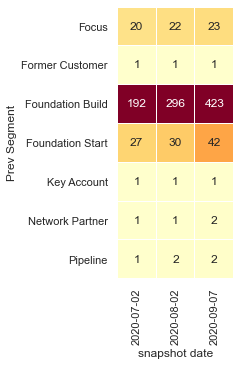

In [50]:
print("#####################################")
print(" segmented from")
print("#####################################")
plt.figure(figsize = (10, 5))

sns.set(font_scale = 1)
sns.heatmap(summary_focus_bysource, annot=True,  annot_kws={"size": 12} #configure font
            , linewidth=.1, vmax=99, fmt='.0f', cmap='YlOrRd', square=True, cbar=False)

plt.xlabel("snapshot date")
plt.ylabel("Prev Segment")


In [31]:
print("#####################################")
print(" segmented from (after 1 July 2020)")
print("#####################################")

focus_new = pd.DataFrame(focus_snapshot)
focus_new = focus_new[focus_new["Organisation Entry To Segment Date"] >= "2020-01-01"]

df = pd.DataFrame(
                    focus_new.groupby(by = ["Organisation Previous NZTE Segment", "SnapshotNZDate"])["Organisation Key"].nunique()
                    .reset_index(name = "customer_count")
                    .pivot(index = "Organisation Previous NZTE Segment", columns=  "SnapshotNZDate", values = "customer_count")
                    .fillna(0)
)

print("#####################################")
focus_new_B = focus_new[(focus_new["Organisation Previous NZTE Segment"] == "Foundation Build")] 
focus_new_B = focus_new_B[["Organisation Key","Organisation Legal Name","Organisation Entry To Segment Date","Organisation NZTE Sector"]].drop_duplicates().sort_values(by = "Organisation Legal Name")

print(" From foundation : ", focus_new_B.shape)

#####################################
 segmented from (after 1 July 2020)
#####################################
#####################################
 From foundation :  (278, 4)


In [33]:
df.

SnapshotNZDate,2020-02-02,2020-03-02,2020-04-02,2020-04-28,2020-05-02,2020-06-02,2020-06-03,2020-06-19,2020-07-02,2020-08-02,2020-09-07
Organisation Previous NZTE Segment,,,,,,,,,,,
Focus,0,0,1,1,1,2,2,2,3,6,8
Foundation Build,2,6,10,18,18,24,24,29,44,148,275
Foundation Start,2,3,4,4,4,5,5,10,12,16,28
Network Partner,0,0,0,1,1,1,1,1,1,1,2
Pipeline,1,1,1,1,1,1,1,1,1,2,2


In [226]:
##############################################################################################################
#Read from a exported file as at certain date
##############################################################################################################
# All OUTCOMES
outcomes_last3yr= pd.read_csv(outDir + 'outcome_last3yr20200911.csv') #, parse_dates= ["Date"] , date_parser= mydateparser)

#join with outcomes
focus_outcomes = focus_new_B.merge(outcomes_last3yr, on='Organisation Key', how='left')
            
focus_outcomes['Deals'] = [1.0 if x == "Deal" else 0.0 for x in focus_outcomes['Outcome Stage']]
focus_outcomes["IGOs"] = [1.0 if x == "IGO" else 0.0 for x in focus_outcomes['Outcome Stage']]
focus_outcomes["outcomes"] = focus_with_outcomes["Deals"] + focus_outcomes["IGOs"]
focus_outcomes["outcome_fy"] = pd.DatetimeIndex(focus_outcomes['Outcome Approval Date']).year

print("###############################################################################################################")
focus_with_outcomes= focus_outcomes[focus_outcomes["outcomes"] == 1]
print(" - New focus vs. outcomes last 3 years (n = ", focus_with_outcomes["Organisation Key"].nunique(), ")")

focus_with_outcomes_aftr_engage = focus_with_outcomes[focus_outcomes["Outcome Approval Date"] >= "2020-07-01"]
print(" - how many with outcomes after segmented in (n = ", focus_with_outcomes_aftr_engage["Organisation Key"].nunique(), ")")
print("###############################################################################################################")
df = (focus_with_outcomes.groupby(["Outcome Stage", "outcome_fy"])["Organisation Key"].nunique()
        .reset_index(name = "customer_count")
        .pivot(index = ["Outcome Stage"], columns= "outcome_fy", values = "customer_count")
)
print(df)

print("###############################################################################################################")
print(" list New focus vs. outcomes last 3 years ")
print("###############################################################################################################")
df = (focus_with_outcomes.groupby(["Organisation Legal Name","Organisation Entry To Segment Date", "outcome_fy", "Outcome Market","Organisation NZTE Sector"])["outcomes"].sum()
       .reset_index()
       .sort_values(by ="outcomes", ascending = False)
    )
       #.pivot(index = ["Organisation Legal Name"], columns= "outcome_fy", values = "Deals")
print(df)

print("##########################################################################")
print("# of focus customers with or without outcomes")
print("##########################################################################")
#focus_with_outcomes[""]

print("##########################################################################")
print("# deals and IGOs distribution and over time")
print("##########################################################################")
#focus_with_outcomes[""]


###############################################################################################################
 - New focus v.s. outcomes last 3 years (n =  37 )
 - how many with outcomes after segmented in (n =  9 )
###############################################################################################################
outcome_fy     2018  2019  2020
Outcome Stage                  
Deal              5    12     7
IGO               4    11    13
###############################################################################################################
 list New focus v.s. outcomes last 3 years 
###############################################################################################################
                             Organisation Legal Name  \
15                          Freshmax Exports Limited   
29                                     Nomos Limited   
36            Scott Package Handling Systems Limited   
3                          Carrfields Grain and Se

In [176]:
focus_with_outcomes.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 261 entries, 0 to 260
Data columns (total 15 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Organisation Key                    261 non-null    object 
 1   Organisation Legal Name             261 non-null    object 
 2   Organisation Entry To Segment Date  261 non-null    object 
 3   Outcome Stage                       64 non-null     object 
 4   Outcome Key                         64 non-null     object 
 5   Outcome IGO Subclassification       64 non-null     object 
 6   Outcome Calculated Amount (NZD)     30 non-null     float64
 7   Outcome Meets Guidelines            64 non-null     object 
 8   Outcome GamePlan Key                7 non-null      object 
 9   Outcome Approval Date               64 non-null     object 
 10  Outcome Market                      63 non-null     object 
 11  Outcome Market Offshore Region      63 non-nu

In [ ]:
#df_Focus.groupby(by = ["Organisation NZTE Sector"]).size()
plt.figure(figsize = (10, 5))
sns.countplot(df_Focus['Organisation NZTE Sector'])

In [ ]:
#Plot categorical variables
categorical = [
    "Organisation NZTE Sector", "Focus Aging Group", "Revenue Band (Int'l)", "Revenue Band (Total)", "Declining Int'l Revenue", "Declining Total Revenue"
]

fig, ax = plt.subplots(2, 3, figsize=(20, 5))

plt.subplots_adjust(hspace = 1)

for variable, subplot in zip(categorical, ax.flatten()):
    sns.countplot(df_Focus[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(55)
        

In [ ]:
#pivot around Declining Revenue
all_categorical = [
    "Organisation NZTE Sector", "Focus Aging Group", "Revenue Band (Int'l)", "Revenue Band (Total)", "Declining Int'l Revenue"
]

interested_categorical = [
    "Organisation NZTE Sector", "Focus Aging Group", "Revenue Band (Int'l)" #, "Revenue Band (Total)"
]

summary = df_Focus.groupby(by = all_categorical)["Customer"].size().reset_index()

summary
#summary.pivot(index = "Organisation NZTE Sector", columns = "Declining Int'l Revenue", values  = "Customer")#.unstack().fillna(0)


In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(20, 5))

plt.subplots_adjust(hspace = 1)

for variable, subplot in zip(categorical, ax.flatten()):
    sns.boxplot(
        data = summary,
        x = variable,
        y = "Customer",
        ax=subplot
    )
    for label in subplot.get_xticklabels():
        label.set_rotation(55)


In [39]:
##############################################################################################################
#Read from a exported file as at certain date
##############################################################################################################
# OGT
ogt = pd.read_csv(outDir + 'ogt_engagement20200914.csv') #, parse_dates= ["Date"] , date_parser= mydateparser)
ogt.shape

##############################################################################################################
#Feature Engineering
##############################################################################################################
#replace focus700 with focus
ogt["Segment_s"] = ogt['Segment_s'].replace(['Focus 700'],'Focus')
#added flag for new focus segmented in after 1July 2020
ogt["new_focus"] = [1.0 if x >= "2020-07-01" else 0.0 for x in ogt["Organisation Entry To Segment Date"]]


<AxesSubplot:xlabel='Sector', ylabel='customer_count'>

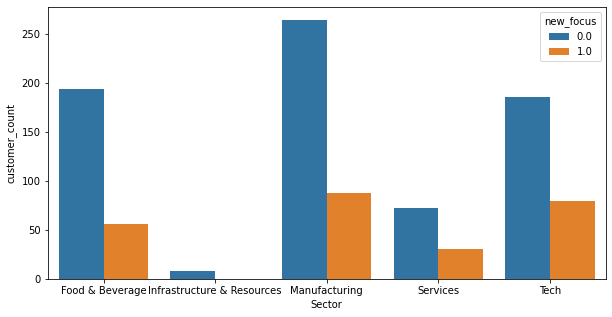

In [29]:
by_sector = ogt[["Organisation Legal Name", "Sector", "new_focus"]].drop_duplicates().assign(customer_count = 1.0)
by_sector = by_sector.groupby(["Sector", "new_focus"])["customer_count"].sum().reset_index()
plt.figure(figsize = (10, 5))
sns.barplot(data = by_sector, x = "Sector", y = "customer_count", hue = "new_focus")

In [40]:
sns.heatmap(data = ogt, )

plt.figure(figsize = (10, 5))

sns.set(font_scale = 1)
sns.heatmap(summary_focus_bysource, annot=True,  annot_kws={"size": 12} #configure font
            , linewidth=.1, vmax=99, fmt='.0f', cmap='YlOrRd', square=True, cbar=False)

plt.xlabel("snapshot date")
plt.ylabel("Prev Segment")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16017 entries, 0 to 16016
Data columns (total 12 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Organisation Key                    16017 non-null  object 
 1   Organisation Legal Name             16017 non-null  object 
 2   Organisation Entry To Segment Date  16017 non-null  object 
 3   Maori Customer                      16017 non-null  object 
 4   Sector                              16016 non-null  object 
 5   Segment_s                           16017 non-null  object 
 6   SnapshotNZDate_s                    16017 non-null  object 
 7   Investment Deals                    2646 non-null   float64
 8   Active IGF Funds                    16017 non-null  int64  
 9   iPlan Projects in Last 12 Months    16017 non-null  int64  
 10  Service Actions                     16017 non-null  int64  
 11  new_focus                           16017

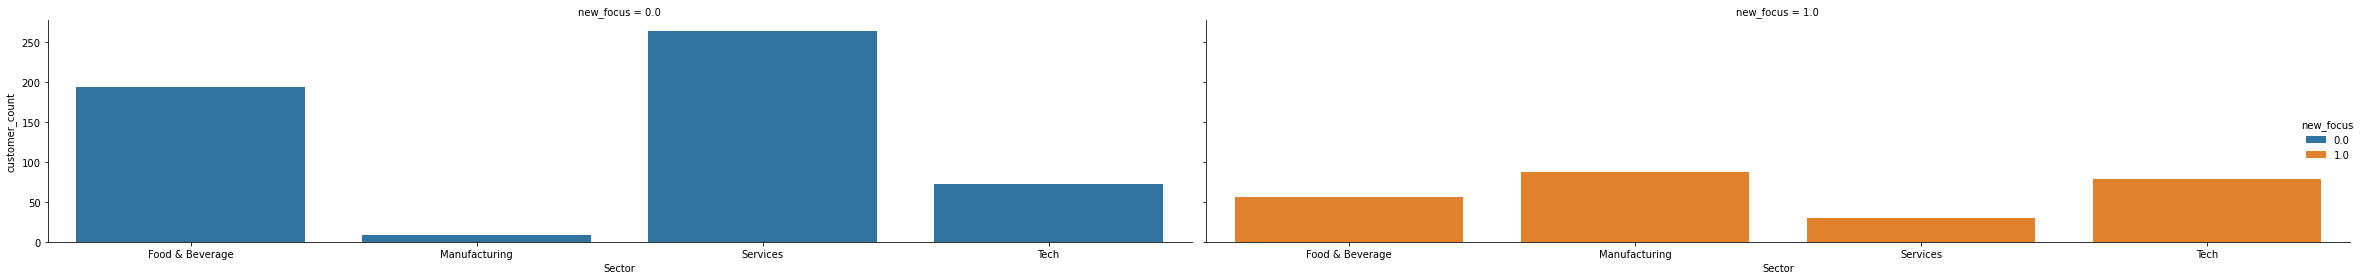

In [36]:
#added feature to count customer
by_sector = ogt[["Organisation Legal Name", "Sector", "new_focus"]].drop_duplicates().assign(customer_count = 1.0)
by_sector = by_sector.groupby(["Sector", "new_focus"])["customer_count"].sum().reset_index()

##############################
#plot
##############################
g = sns.FacetGrid(by_sector, col = "new_focus", hue = "new_focus", height = 4, aspect = 2)

#g.map(sns.boxplot, data = manufacturing_deals,  x = "Deal Amount", y = "Fiscal Year", palette = "muted")
g.map(sns.barplot, "Sector", "customer_count" )
g.add_legend()
for ax in g.axes.flatten():
    ax.tick_params(labelbottom = True)
plt.tight_layout()
plt.show()

In [43]:
ogt.query('Segment_s.str.contains("Focus")', engine = 'python')
by_sector.shape

(1012, 2)